In [14]:
# Install required libraries
!pip install pandas scikit-learn matplotlib seaborn --quiet

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Load the Enron dataset or use serialized data if available
if os.path.exists('enron_spam_data_corrected.pkl'):
    with open('enron_spam_data_corrected.pkl', 'rb') as f:
        data = pickle.load(f)
else:
    from google.colab import files
    uploaded = files.upload()
    data = pd.read_csv('enron_spam_data.csv')

# Check the columns to understand the structure of the dataset
print("Columns in dataset:", data.columns)

# Step 1: Combine 'Subject' and 'Message' into a single text column if they exist
if 'Subject' in data.columns and 'Message' in data.columns:
    data['text'] = data['Subject'].fillna('') + " " + data['Message'].fillna('')
else:
    data['text'] = data[data.columns[0]].fillna('')

# Drop unnecessary columns
data = data[['text', 'Spam/Ham']] if 'Spam/Ham' in data.columns else data

Saving enron_spam_data.csv to enron_spam_data (1).csv


<ipython-input-14-781a12d77a5d>:22: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265

Columns in dataset: Index(['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 414', 'Unnamed: 415', 'Unnamed: 416', 'Unnamed: 417',
       'Unnamed: 418', 'Unnamed: 419', 'Unnamed: 420', 'Unnamed: 421',
       'Unnamed: 422', 'Unnamed: 423'],
      dtype='object', length=424)


Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3245
         1.0       0.98      0.99      0.99      3483

    accuracy                           0.99      6728
   macro avg       0.99      0.99      0.99      6728
weighted avg       0.99      0.99      0.99      6728



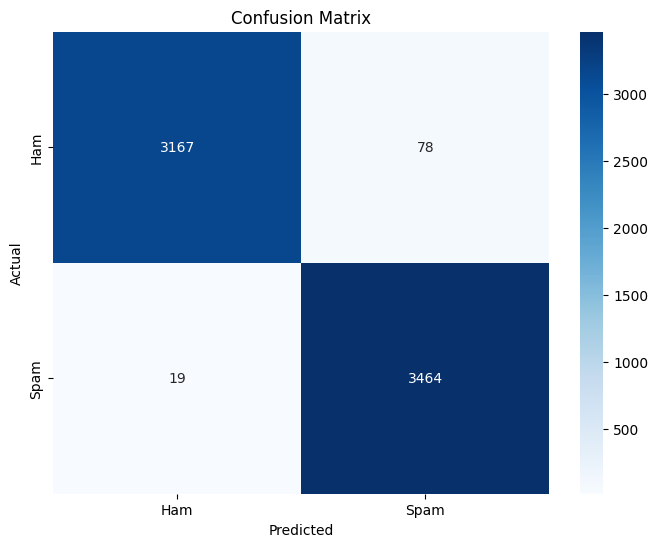

In [15]:
# Step 2: Map target labels: 'spam' -> 1, 'ham' -> 0
# Use .loc[] to avoid SettingWithCopyWarning and drop rows with missing labels
data = data.dropna(subset=['Spam/Ham'])
data = data.copy()  # Create a deep copy to avoid SettingWithCopyWarning
data['label'] = data['Spam/Ham'].map({'spam': 1, 'ham': 0})

# Drop rows with missing labels after mapping
data = data.dropna(subset=['label'])

# Preprocess text: Lowercase and strip whitespace
data['text'] = data['text'].str.lower().str.strip()

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Train a Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = model.predict(X_test_tfidf)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}\n")
print("Classification Report:\n", classification_rep)

# Step 7: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
# Step 8: Function to classify user-provided emails by leveraging the full dataset
def classify_email():
    """
    Prompt the user to input an email and classify it as Spam or Ham.
    Use the existing model trained on the full dataset to make a prediction.
    Allow the user to overwrite the classification if necessary.
    """
    global data
    email_content = input("Enter the email content (subject and body): ")
    email_content = email_content.lower().strip()  # Preprocess the input
    email_tfidf = vectorizer.transform([email_content])  # Vectorize the input

    # Train the model on the entire dataset for better accuracy
    X_full_tfidf = vectorizer.fit_transform(data['text'])
    model.fit(X_full_tfidf, data['label'])

    # Make a prediction on the user-provided email
    prediction = model.predict(email_tfidf)[0]  # Predict the class
    result = 'Spam' if prediction == 1 else 'Ham'
    print(f"The email is classified as: {result}")

    # Allow the user to overwrite the classification
    actual_label = input("Is this classification correct? (yes/no): ").strip().lower()
    if actual_label == 'no':
        correct_label = input("Please provide the correct label (Spam/Ham): ").strip().lower()
        if correct_label in ['spam', 'ham']:
            correct_label_num = 1 if correct_label == 'spam' else 0
            # Add the user-provided correction back to the dataset for future training
            new_entry = pd.DataFrame({'text': [email_content], 'label': [correct_label_num]})
            data = pd.concat([data, new_entry], ignore_index=True)
            # Serialize the updated dataset using pickle
            with open('enron_spam_data_corrected.pkl', 'wb') as f:
                pickle.dump(data, f)
            print("The corrected label has been saved and added to the training data.")

# Run the email classification function
classify_email()


Enter the email content (subject and body): Get a special Black Friday deal for dedicated IP  A dedicated IP lets you:      Access websites that block VPN connections.     Skip annoying “select images with cars” boxes.     Enjoy smoother online banking.     Access secured work resources remotely.  Take advantage of our Black Friday deal: Get 20% off on a 6-month plan, which comes down to $4.69/month ($28.14 in total). Special Black Friday offer for dedicated IP  The offer* is valid for 5 days. This deal always recurs at the same price. Get Dedicated IP  To use a dedicated IP, you need to buy it separately, in addition to an active NordVPN subscription.  Stay safe! The NordVPN team   What is a dedicated/personal IP?  Each time you connect to a VPN, you’re assigned a dynamic IP. With a dedicated IP, you get one IP address in a location of your choice — and it always stays the same.
The email is classified as: Ham
Is this classification correct? (yes/no): yes
